In [1]:
# 🧩 1. Install + Imports
%pip install -q scikit-learn

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import numpy as np
import pandas as pd
import random
import shutil

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Note: you may need to restart the kernel to use updated packages.


c:\Users\Lenovo\anaconda3\envs\PlantDisease\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# 🧩 2. Reduce Dataset (Training + Validation)
import random
import shutil

def create_temp_dataset(original_dir, temp_dir, max_per_class=1000, seed=42):
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    random.seed(seed)
    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected = random.sample(images, min(len(images), max_per_class))
            target_class_dir = os.path.join(temp_dir, class_name)
            os.makedirs(target_class_dir)
            for img in selected:
                src = os.path.join(class_path, img)
                dst = os.path.join(target_class_dir, img)
                shutil.copyfile(src, dst)

def load_dataset_from_temp(temp_dir, img_size=(128, 128), batch_size=16):
    dataset = tf.keras.utils.image_dataset_from_directory(
        temp_dir,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        label_mode='categorical'
    )
    return dataset

In [4]:
# 🧩 3. Apply Reduction
# Paths
original_train_path = "train"
original_val_path = "val"
temp_train_path = "Dataset/Reduced_Train"
temp_val_path = "Dataset/Reduced_Val"

# Reduce
create_temp_dataset(original_train_path, temp_train_path, max_per_class=500)
create_temp_dataset(original_val_path, temp_val_path, max_per_class=100)

# Load reduced datasets
train_ds = load_dataset_from_temp(temp_train_path, img_size=(224, 224), batch_size=32)
val_ds = load_dataset_from_temp(temp_val_path, img_size=(224, 224), batch_size=32)

# Load test dataset (full)
test_ds = image_dataset_from_directory('test', image_size=(224, 224), batch_size=64, label_mode='categorical', shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 2000 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 968 files belonging to 4 classes.


In [5]:
# 🧩 4. Build Model
def build_model(base_model_name, input_shape=(224, 224, 3), num_classes=4):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.MobileNetV3Large(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet',
            include_preprocessing=True
        )
    elif base_model_name == 'resnet':
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'vgg':
        base_model = tf.keras.applications.VGG16(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError("Unsupported model name")

    base_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [6]:
# 🧩 5. Training Function
def train_model(model, train_data, val_data, epochs, model_name):
    print(f"\n🚀 Training {model_name}...")
    start = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    end = time.time()

    model.save(f'{model_name}_model.keras')
    with open(f'{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ {model_name} training completed in {(end - start):.2f} seconds.")
    return history, end - start

In [7]:
# 🧩 6. Train All Models
mobilenet_model = build_model('mobilenet')
mobilenet_history, mobilenet_time = train_model(mobilenet_model, train_ds, val_ds, epochs=10, model_name='mobilenetv3')

resnet_model = build_model('resnet')
resnet_history, resnet_time = train_model(resnet_model, train_ds, val_ds, epochs=10, model_name='resnet50')

vgg_model = build_model('vgg')
vgg_history, vgg_time = train_model(vgg_model, train_ds, val_ds, epochs=10, model_name='vgg16')


🚀 Training mobilenetv3...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.3161 - loss: 1.9241 - val_accuracy: 0.7188 - val_loss: 0.8136
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.5080 - loss: 1.0994 - val_accuracy: 0.8438 - val_loss: 0.5874
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.5839 - loss: 0.9696 - val_accuracy: 0.8750 - val_loss: 0.4721
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.6564 - loss: 0.8561 - val_accuracy: 0.8750 - val_loss: 0.4015
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6777 - loss: 0.7926 - val_accuracy: 0.8750 - val_loss: 0.3579
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.7007 - loss: 0.7547 - val_accuracy: 0.8750 - val_loss: 0.3357
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.7189 - loss: 0.7015 - val_accuracy: 0.9062 - val_loss: 0.3131
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.752

In [8]:
# 🧩 7. Evaluation Function
def evaluate_model_on_test(model, test_ds, model_name="Model"):
    print(f"🔍 Evaluating {model_name} on test set...")

    true_labels = tf.concat([y for x, y in test_ds], axis=0)
    Y_true = tf.argmax(true_labels, axis=1)

    pred_probs = model.predict(test_ds)
    Y_pred = tf.argmax(pred_probs, axis=1)

    acc = accuracy_score(Y_true, Y_pred)
    prec = precision_score(Y_true, Y_pred, average='macro')
    rec = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')

    print("📄 Classification Report:")
    print(classification_report(Y_true, Y_pred))

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

🔍 Evaluating MobileNetV3 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       242
           1       0.92      0.89      0.91       242
           2       0.91      0.86      0.89       242
           3       0.97      0.97      0.97       242

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968



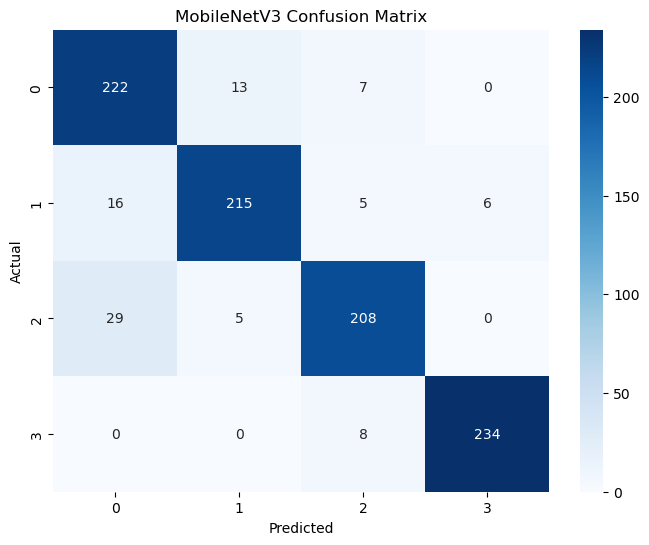

🔍 Evaluating ResNet50 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       242
           1       0.91      0.89      0.90       242
           2       0.92      0.91      0.92       242
           3       0.96      0.98      0.97       242

    accuracy                           0.92       968
   macro avg       0.92      0.92      0.92       968
weighted avg       0.92      0.92      0.92       968



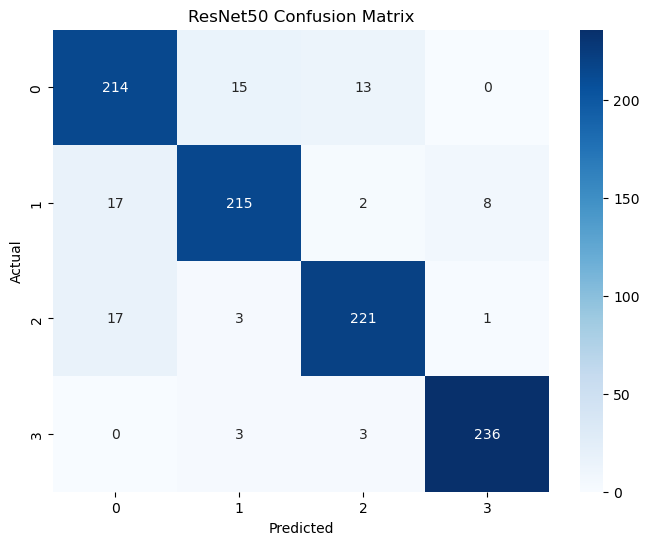

🔍 Evaluating VGG16 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       242
           1       0.78      0.81      0.80       242
           2       0.82      0.71      0.76       242
           3       0.88      0.93      0.90       242

    accuracy                           0.82       968
   macro avg       0.82      0.82      0.82       968
weighted avg       0.82      0.82      0.82       968



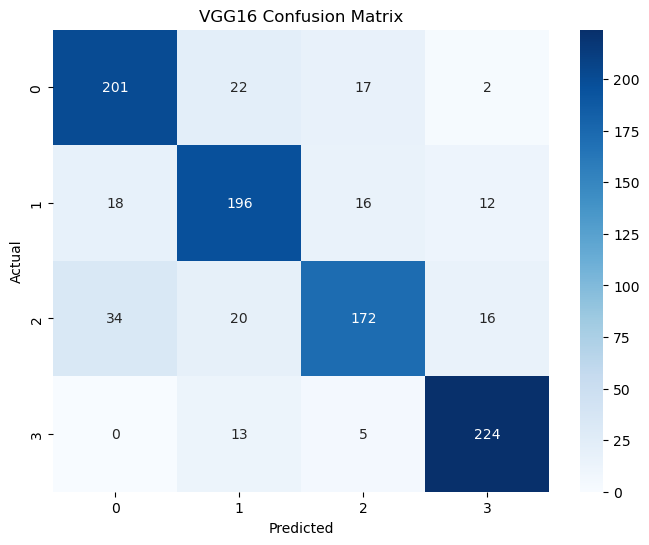

In [9]:
# 🧩 8. Evaluate All Models
mobilenet_results = evaluate_model_on_test(mobilenet_model, test_ds, "MobileNetV3")
resnet_results = evaluate_model_on_test(resnet_model, test_ds, "ResNet50")
vgg_results = evaluate_model_on_test(vgg_model, test_ds, "VGG16")

In [10]:
# 🧩 9. Compare All Models in a Table
mobilenet_size = os.path.getsize('mobilenetv3_model.keras') / (1024 * 1024)
resnet_size = os.path.getsize('resnet50_model.keras') / (1024 * 1024)
vgg_size = os.path.getsize('vgg16_model.keras') / (1024 * 1024)

comparison_df = pd.DataFrame([
    {**mobilenet_results, 'Model Size (MB)': mobilenet_size, 'Training Time (s)': mobilenet_time},
    {**resnet_results, 'Model Size (MB)': resnet_size, 'Training Time (s)': resnet_time},
    {**vgg_results, 'Model Size (MB)': vgg_size, 'Training Time (s)': vgg_time}
])

comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,Model Size (MB),Training Time (s)
0,MobileNetV3,0.908058,0.910372,0.908058,0.908406,13.502170,136.065504
1,ResNet50,0.915289,0.915468,0.915289,0.915292,93.617665,698.491575
2,VGG16,0.819215,0.819070,0.819215,0.817885,56.978528,2112.559193


In [11]:
# 🧩 10. Plot Training Curves
def plot_training_curves(history, model_name):
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

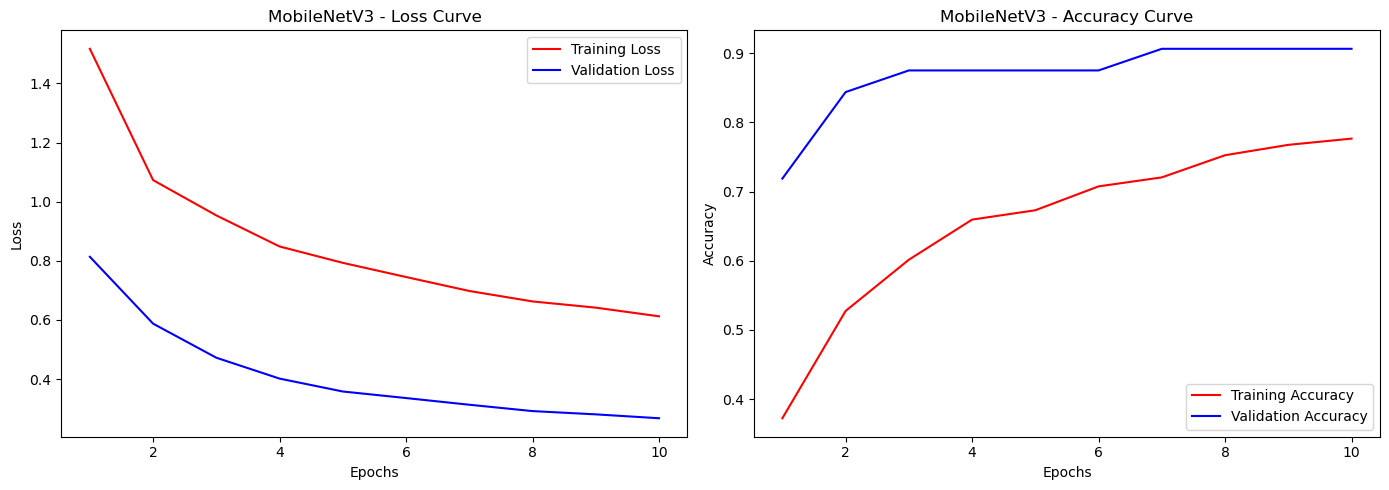

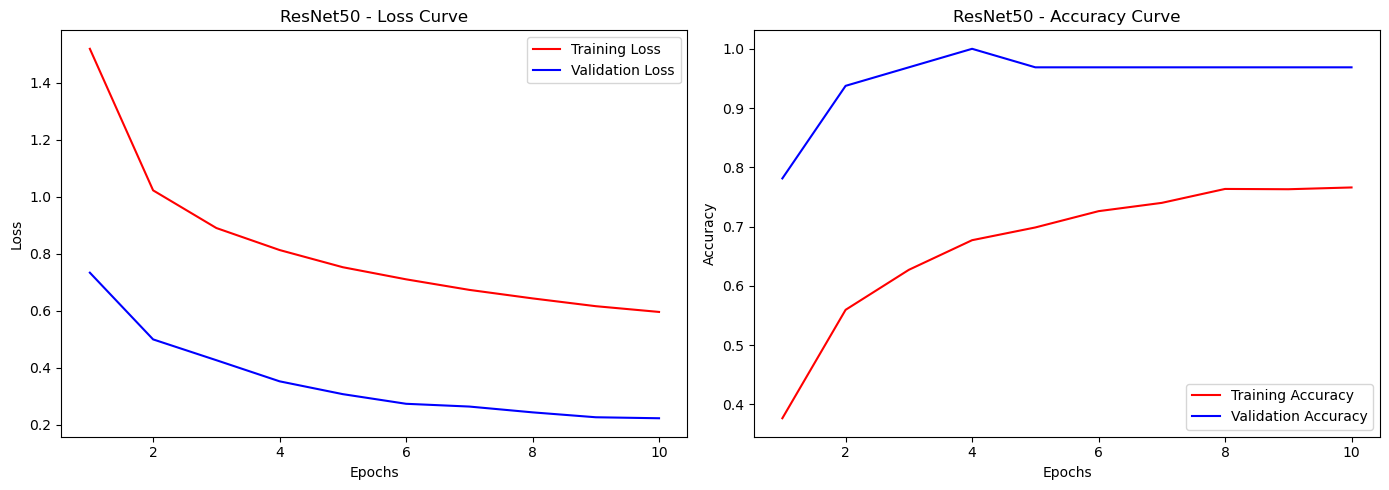

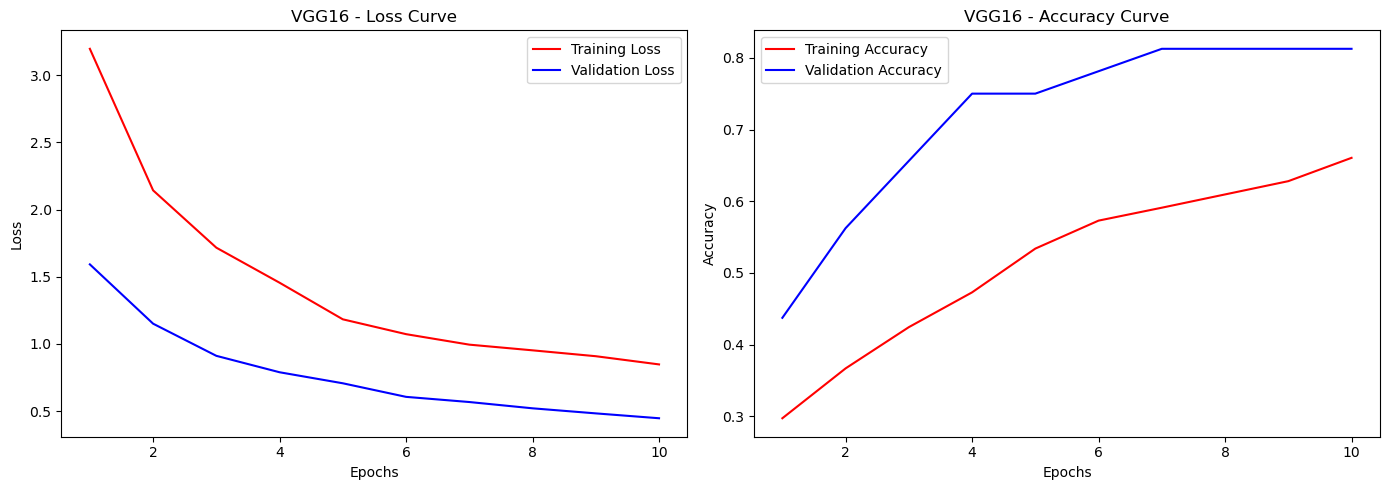

In [12]:
# 🧩 11. Load & Plot Curves
with open('mobilenetv3_history.pkl', 'rb') as f:
    mob_history = pickle.load(f)
plot_training_curves(mob_history, 'MobileNetV3')

with open('resnet50_history.pkl', 'rb') as f:
    resnet_history = pickle.load(f)
plot_training_curves(resnet_history, 'ResNet50')

with open('vgg16_history.pkl', 'rb') as f:
    vgg_history = pickle.load(f)
plot_training_curves(vgg_history, 'VGG16')


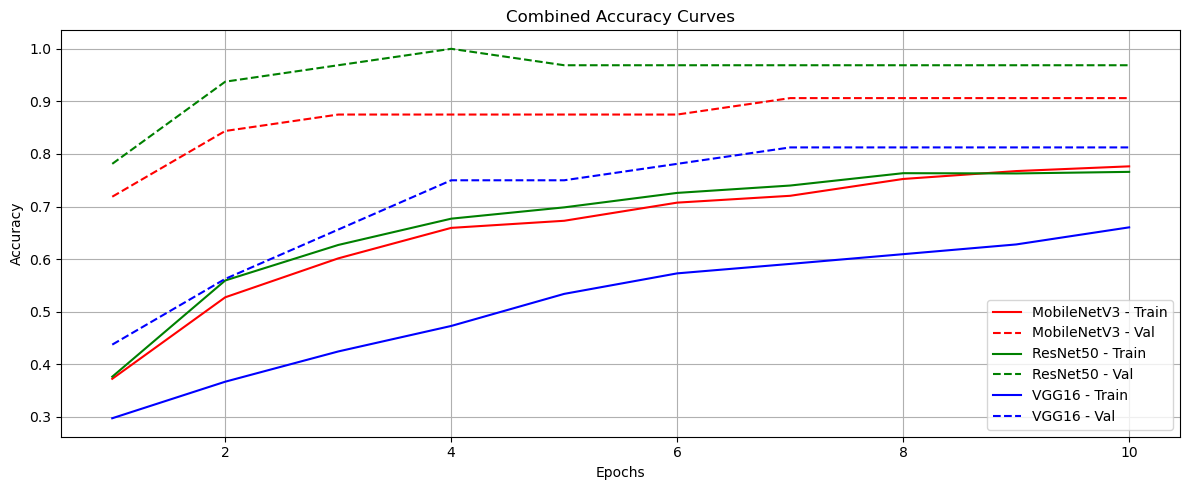

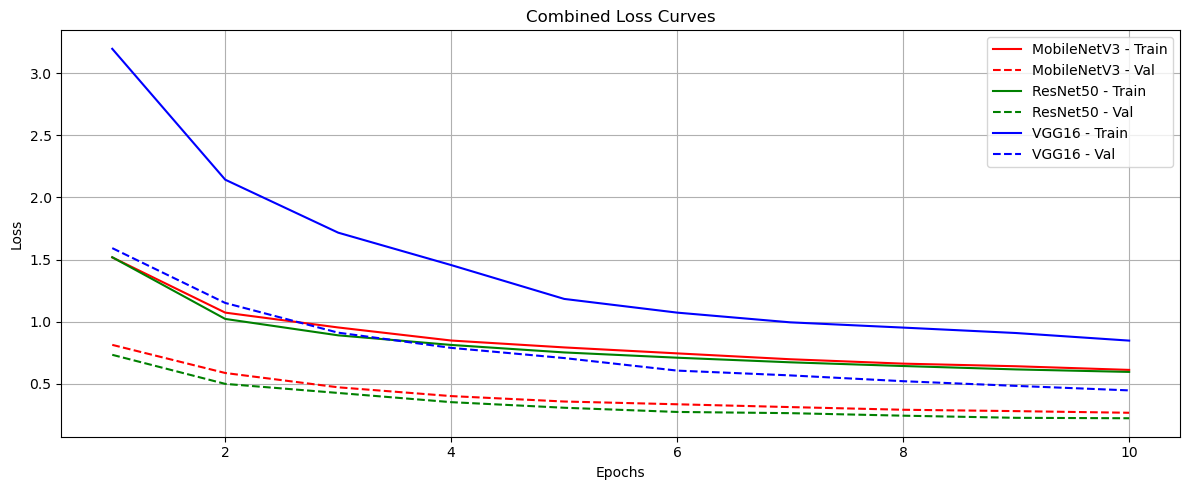

In [13]:
# 🧩 12. Combined Metrics Plot12. Combined Metrics Plot
def plot_combined_metrics():
    models = {
        'MobileNetV3': 'mobilenetv3_history.pkl',
        'ResNet50': 'resnet50_history.pkl',
        'VGG16': 'vgg16_history.pkl'
    }

    colors = {'MobileNetV3': 'r', 'ResNet50': 'g', 'VGG16': 'b'}
    styles = {'train': '-', 'val': '--'}

    plt.figure(figsize=(12, 5))
    for name, file in models.items():
        with open(file, 'rb') as f:
            hist = pickle.load(f)
        epochs = range(1, len(hist['accuracy']) + 1)
        plt.plot(epochs, hist['accuracy'], color=colors[name], linestyle=styles['train'], label=f'{name} - Train')
        plt.plot(epochs, hist['val_accuracy'], color=colors[name], linestyle=styles['val'], label=f'{name} - Val')
    plt.title('Combined Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    for name, file in models.items():
        with open(file, 'rb') as f:
            hist = pickle.load(f)
        epochs = range(1, len(hist['loss']) + 1)
        plt.plot(epochs, hist['loss'], color=colors[name], linestyle=styles['train'], label=f'{name} - Train')
        plt.plot(epochs, hist['val_loss'], color=colors[name], linestyle=styles['val'], label=f'{name} - Val')
    plt.title('Combined Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_metrics()